

En este notebook implementa un auntoencoder usando un dataset de ventas de videojuegos



## 1. Importar librerías

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models

# Fijar semillas para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

print("Versión de TensorFlow:", tf.__version__)

c:\Users\Rodrigo\Downloads\TIEL26_EVA3\venv\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.0) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


Versión de TensorFlow: 2.20.0


Cargar conjunto de datos, revisar valores nulos, revisar variables numericas que se usaran de entrada


In [7]:
# Cargar dataset
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("video_games_sales.csv")

# Mostrar algunas filas de ejemplo
df.head()

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# Información general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rank          16598 non-null  int64  
 1   name          16598 non-null  object 
 2   platform      16598 non-null  object 
 3   year          16327 non-null  float64
 4   genre         16598 non-null  object 
 5   publisher     16540 non-null  object 
 6   na_sales      16598 non-null  float64
 7   eu_sales      16598 non-null  float64
 8   jp_sales      16598 non-null  float64
 9   other_sales   16598 non-null  float64
 10  global_sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [ ]:
# Comprobar valores nulos por columna
df.isna().sum()

,0
rank,0
name,0
platform,0
year,271
genre,0
publisher,58
na_sales,0
eu_sales,0
jp_sales,0
other_sales,0


Preprocesamiento y definición de dimensiones

Pasos:

1. Eliminar filas con `year` nulo
2. Seleccionar un subconjunto de columnas numéricas como entrada del autoencoder  
3. Escalamos los datos a rango `[0, 1]` usando `MinMaxScaler`.  
4. Definimos:
   - `input_dim`: dimensión de entrada  
   - `latent_dim`: dimensión de la representación latente (cuello de botella)


In [ ]:
# 1. Eliminar filas con 'year' nulo
df_clean = df.dropna(subset=["year"]).reset_index(drop=True)

# 2. Seleccionar columnas numéricas para el autoencoder
features = ["year", "na_sales", "eu_sales", "jp_sales", "other_sales", "global_sales"]
X = df_clean[features].values

# 3. Escalar los datos al rango [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 4. Crear etiquetas binarias para una tarea supervisada sencilla (ventas altas / bajas)
y_all = (df_clean["global_sales"] >= 1.0).astype(int).values  # 1 si global_sales >= 1.0, 0 en caso contrario

# Dividir en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# Dimensiones
input_dim = X_train.shape[1]
latent_dim = 2  # elegimos 2 para poder visualizar fácilmente la representación latente

print("Características usadas:", features)
print("Dimensión de entrada (input_dim):", input_dim)
print("Dimensión de la representación latente (latent_dim):", latent_dim)
print("Tamaño de entrenamiento:", X_train.shape)
print("Tamaño de validación:", X_val.shape)

Características usadas: ['year', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'global_sales']
Dimensión de entrada (input_dim): 6
Dimensión de la representación latente (latent_dim): 2
Tamaño de entrenamiento: (13061, 6)
Tamaño de validación: (3266, 6)


Definir el codificador (encoder) y el decodificador (decoder)

- El **encoder** comprime la información desde `input_dim` hasta `latent_dim`.  
- El **decoder** toma la representación latente y reconstruye la entrada original.


In [ ]:
# Definición del codificador (encoder)
input_layer = layers.Input(shape=(input_dim,), name="input")
x = layers.Dense(32, activation="relu", name="enc_dense_1")(input_layer)
x = layers.Dense(16, activation="relu", name="enc_dense_2")(x)
latent = layers.Dense(latent_dim, activation="linear", name="latent")(x)

encoder = models.Model(inputs=input_layer, outputs=latent, name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_1 (Dense)             │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_2 (Dense)             │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 786 (3.07 KB)

 Trainable params: 786 (3.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Definición del decodificador (decoder)
latent_inputs = layers.Input(shape=(latent_dim,), name="decoder_input")
x = layers.Dense(16, activation="relu", name="dec_dense_1")(latent_inputs)
x = layers.Dense(32, activation="relu", name="dec_dense_2")(x)
output_layer = layers.Dense(input_dim, activation="sigmoid", name="decoder_output")(x)

decoder = models.Model(inputs=latent_inputs, outputs=output_layer, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_1 (Dense)             │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_2 (Dense)             │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 790 (3.09 KB)

 Trainable params: 790 (3.09 KB)

 Non-trainable params: 0 (0.00 B)

Crear el modelo autoencoder completo

El **autoencoder** encadena:

\( \text{entrada} \rightarrow \text{encoder} \rightarrow \text{decoder} \rightarrow \text{salida reconstruida} \)

La red se entrena para minimizar la diferencia entre la entrada original y la salida reconstruida (error de reconstrucción).


In [ ]:
# Conectar encoder y decoder para formar el autoencoder
autoencoder_input = input_layer
autoencoder_output = decoder(encoder(autoencoder_input))

autoencoder = models.Model(inputs=autoencoder_input,
                           outputs=autoencoder_output,
                           name="autoencoder")

autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 2)              │           786 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 6)              │           790 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,576 (6.16 KB)

 Trainable params: 1,576 (6.16 KB)

 Non-trainable params: 0 (0.00 B)

Compilar, entrenar y evaluar el autoencoder

- Usar `MSE` (error cuadrático medio) como función de pérdida.  
- Optimizador: `Adam`.  
- Entrenar el modelo tratando de reconstruir los datos de entrada.

Luego:
- Graficar la evolución de la pérdida (entrenamiento y validación).  
- Calcular el error de reconstrucción en el conjunto de validación.


In [ ]:
# Compilar el autoencoder
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse"
)

# Entrenar el modelo
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    shuffle=True,
    validation_data=(X_val, X_val),
    verbose=1
)

Epoch 1/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1348 - val_loss: 0.0034
Epoch 2/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 3/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0017 - val_loss: 5.1670e-04
Epoch 4/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.9739e-04 - val_loss: 4.5826e-04
Epoch 5/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.5235e-04 - val_loss: 3.2646e-04
Epoch 6/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.6964e-04 - val_loss: 2.5830e-04
Epoch 7/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1860e-04 - val_loss: 2.3594e-04
Epoch 8/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9895e-04 - val_loss: 2.1747e-04
Epoch 9/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8214e-04 - val_loss: 2.0259e-04
Epoch 10/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6954e-04 - val_loss: 1.8916e-04
Epoch 11/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.5893e-04 - val_l

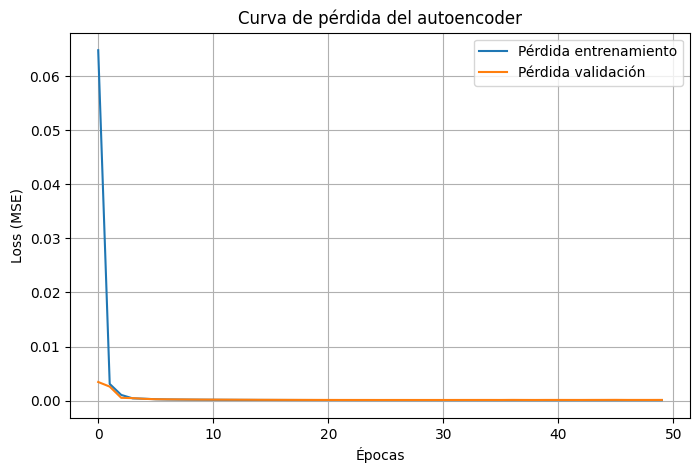

In [ ]:
# Graficar la curva de pérdida
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Pérdida entrenamiento")
plt.plot(history.history["val_loss"], label="Pérdida validación")
plt.xlabel("Épocas")
plt.ylabel("Loss (MSE)")
plt.title("Curva de pérdida del autoencoder")
plt.legend()
plt.grid(True)
plt.show()

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Error medio de reconstrucción (validación): 0.00012856582891837917
Desviación estándar del error de reconstrucción: 0.002191480406101599


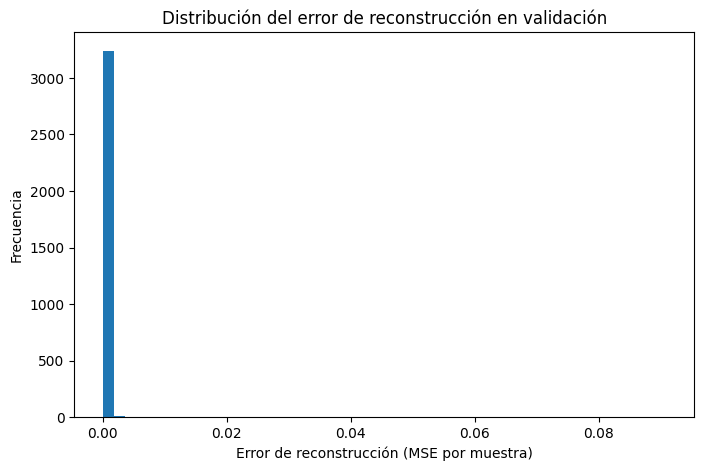

In [ ]:
# Evaluar error de reconstrucción en el conjunto de validación
X_val_pred = autoencoder.predict(X_val)
reconstruction_error = np.mean(np.square(X_val - X_val_pred), axis=1)

print("Error medio de reconstrucción (validación):", reconstruction_error.mean())
print("Desviación estándar del error de reconstrucción:", reconstruction_error.std())

plt.figure(figsize=(8, 5))
plt.hist(reconstruction_error, bins=50)
plt.xlabel("Error de reconstrucción (MSE por muestra)")
plt.ylabel("Frecuencia")
plt.title("Distribución del error de reconstrucción en validación")
plt.show()

Modelo codificador y visualización de la representación latente

El modelo encoder por sí solo nos permite obtener la representación latente de cualquier muestra.

Aquí:

- Calcular la representación latente de las muestras de validación.  
- Como `latent_dim = 2`, podemos dibujar un **scatter plot 2D**.  
- Coloreamos los puntos según si el videojuego tiene ventas globales altas o bajas (según el umbral que usamos antes).

Esto ilustra cómo el autoencoder aprende una estructura interna de los datos.


103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


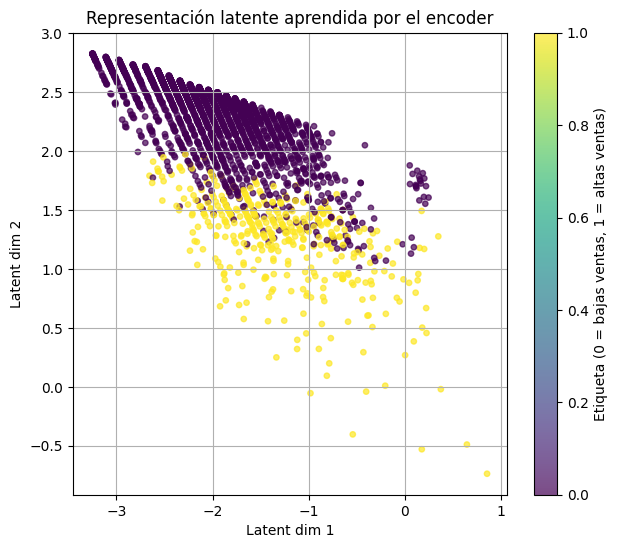

In [ ]:
# Obtener representación latente de las muestras de validación
X_val_latent = encoder.predict(X_val)

# Gráfico 2D de la representación latente
plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    X_val_latent[:, 0],
    X_val_latent[:, 1],
    c=y_val,  # 0 = bajas ventas, 1 = altas ventas
    cmap="viridis",
    alpha=0.7,
    s=15
)
plt.colorbar(scatter, label="Etiqueta (0 = bajas ventas, 1 = altas ventas)")
plt.xlabel("Latent dim 1")
plt.ylabel("Latent dim 2")
plt.title("Representación latente aprendida por el encoder")
plt.grid(True)
plt.show()

Fine-tuning: usar el encoder pre-entrenado para una tarea supervisada

Para conectar con la idea de fine-tuning, haremos lo siguiente:

1. Usaremos el encoder pre-entrenado como extractor de características.  
2. Definiremos una tarea supervisada simple:  
   - Predecir si un videojuego tiene ventas globales altas (≥ 1 millón) o bajas.  
3. Entrenaremos un modelo de clasificación en dos fases:
   - Fase 1: Encoder congelado (no se actualizan sus pesos).  
   - Fase 2: Hacemos fine-tuning (descongelamos el encoder y entrenamos con una tasa de aprendizaje más pequeña).

Esto muestra cómo:

- Primero se hace un pre-entrenamiento no supervisado (autoencoder).  
- Luego se ajusta finamente el modelo para una tarea específica (clasificación).

In [ ]:
# Fase 1: usar el encoder como extractor de características congelado

# Congelar pesos del encoder
encoder.trainable = False

clf_input = layers.Input(shape=(input_dim,), name="clf_input")
x = encoder(clf_input)
x = layers.Dense(16, activation="relu", name="clf_dense")(x)
clf_output = layers.Dense(1, activation="sigmoid", name="clf_output")(x)

classifier = models.Model(inputs=clf_input, outputs=clf_output, name="classifier_frozen")

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_clf_frozen = classifier.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8425 - loss: 0.5433 - val_accuracy: 0.8766 - val_loss: 0.2945
Epoch 2/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8776 - loss: 0.2753 - val_accuracy: 0.8833 - val_loss: 0.2432
Epoch 3/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8876 - loss: 0.2282 - val_accuracy: 0.9051 - val_loss: 0.2008
Epoch 4/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9080 - loss: 0.1874 - val_accuracy: 0.9170 - val_loss: 0.1659
Epoch 5/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9242 - loss: 0.1540 - val_accuracy: 0.9326 - val_loss: 0.1411
Epoch 6/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9390 - loss: 0.1311 - val_accuracy: 0.9473 - val_loss: 0.1250
Epoch 7/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9495 - loss: 0.1164 - val_accuracy: 0.9498 - val_loss: 0.1148
Epoch 8/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9538 - loss: 0.1069 - val_accuracy: 0.

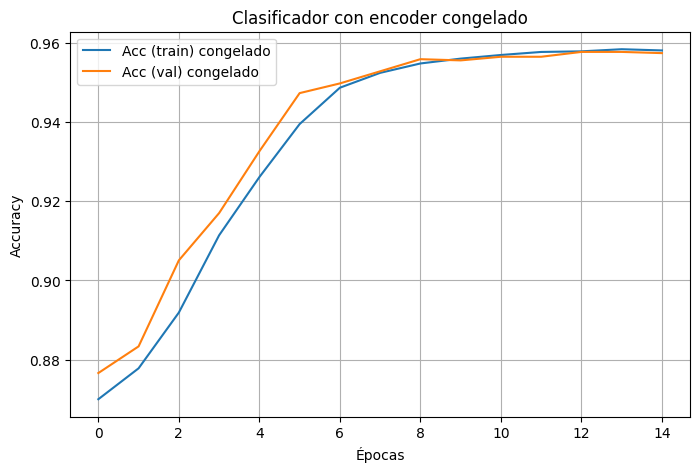

In [ ]:
# Desempeño con encoder congelado
plt.figure(figsize=(8, 5))
plt.plot(history_clf_frozen.history["accuracy"], label="Acc (train) congelado")
plt.plot(history_clf_frozen.history["val_accuracy"], label="Acc (val) congelado")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.title("Clasificador con encoder congelado")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Fase 2: fine-tuning (descongelar el encoder y seguir entrenando)

encoder.trainable = True

# IMPORTANTE: recompilar el modelo para que tenga en cuenta los pesos ahora entrenables
classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # LR más pequeño para fine-tuning
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_clf_ft = classifier.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9624 - loss: 0.0839 - val_accuracy: 0.9626 - val_loss: 0.0842
Epoch 2/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9681 - loss: 0.0753 - val_accuracy: 0.9639 - val_loss: 0.0782
Epoch 3/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9704 - loss: 0.0698 - val_accuracy: 0.9660 - val_loss: 0.0732
Epoch 4/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9726 - loss: 0.0653 - val_accuracy: 0.9682 - val_loss: 0.0688
Epoch 5/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9738 - loss: 0.0614 - val_accuracy: 0.9706 - val_loss: 0.0649
Epoch 6/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9761 - loss: 0.0579 - val_accuracy: 0.9718 - val_loss: 0.0614
Epoch 7/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9778 - loss: 0.0548 - val_accuracy: 0.9740 - val_loss: 0.0582
Epoch 8/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9792 - loss: 0.0519 - val_accuracy: 0.

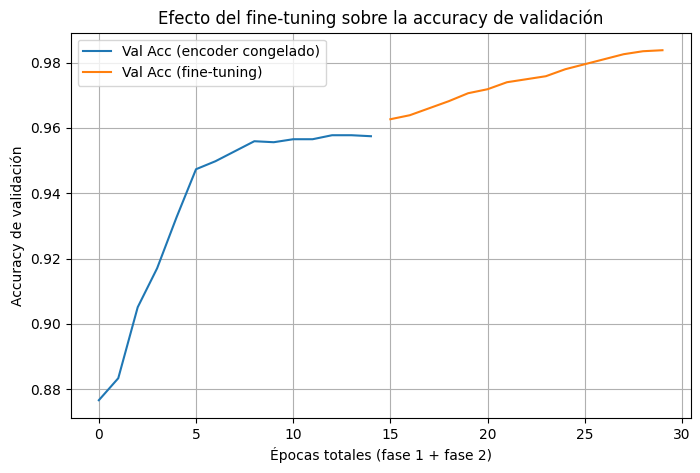

In [ ]:
# Desempeño después del fine-tuning
plt.figure(figsize=(8, 5))
plt.plot(history_clf_frozen.history["val_accuracy"], label="Val Acc (encoder congelado)")
plt.plot(range(len(history_clf_frozen.history["val_accuracy"]),
             len(history_clf_frozen.history["val_accuracy"]) + len(history_clf_ft.history["val_accuracy"])),
         history_clf_ft.history["val_accuracy"],
         label="Val Acc (fine-tuning)")
plt.xlabel("Épocas totales (fase 1 + fase 2)")
plt.ylabel("Accuracy de validación")
plt.title("Efecto del fine-tuning sobre la accuracy de validación")
plt.legend()
plt.grid(True)
plt.show()